In [10]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns


In [2]:
# Path to your image dataset
data_dir = '/home/gcekcse/Documents/ML_Project_hk/aptos2019-blindness-detection/G1/G1_images'
labels_file = '/home/gcekcse/Documents/ML_Project_hk/aptos2019-blindness-detection/G1/G1.csv'

# Load labels
df = pd.read_csv(labels_file)

# Split data into training and testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display sample data
print(train_df.head())

           id_code  diagnosis
2181  996f9bba4ef0          0
570   286e9981dd9b          0
3389  eae70f527755          0
343   19244004583f          3
1801  7f0ffeb0a333          0


In [3]:

IMG_SIZE = 224  # Resize images to 224x224

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None  # Skip images that are not loaded
    else:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # Normalize
        return img

def preprocess_data(dataframe, data_dir):
    X = []
    y = []
    for idx, row in dataframe.iterrows():
        img_path = os.path.join(data_dir, row['id_code'] + ".png")  # Assuming .png extension
        img = preprocess_image(img_path)
        
        if img is not None:  # Proceed only if the image was loaded
            X.append(img)
            y.append(row['diagnosis'])  # Assuming 'diagnosis' contains the target label
            
        if idx % 100 == 0:  # Log progress every 100 images
            print(f"Processed {idx + 1}/{len(dataframe)} images.")
    
    return np.array(X), np.array(y)

# Run preprocessing with logging
print("Preprocessing training data...")
X_train, y_train = preprocess_data(train_df, data_dir)

print("Preprocessing test data...")
X_test, y_test = preprocess_data(test_df, data_dir)

print("Preprocessing completed.")

Preprocessing training data...
Processed 2901/2929 images.
Processed 2401/2929 images.
Processed 3401/2929 images.
Processed 3201/2929 images.
Processed 901/2929 images.
Processed 101/2929 images.
Processed 3101/2929 images.
Processed 1601/2929 images.
Processed 1101/2929 images.
Processed 1001/2929 images.
Processed 3001/2929 images.
Processed 301/2929 images.
Processed 2501/2929 images.
Processed 801/2929 images.
Processed 501/2929 images.
Processed 2701/2929 images.
Processed 3301/2929 images.
Processed 3501/2929 images.
Processed 2801/2929 images.
Processed 1701/2929 images.
Processed 1901/2929 images.
Processed 3601/2929 images.
Processed 2101/2929 images.
Processed 2001/2929 images.
Processed 1301/2929 images.
Processed 2201/2929 images.
Processed 401/2929 images.
Processed 1401/2929 images.
Processed 201/2929 images.
Processed 1501/2929 images.
Processed 601/2929 images.
Processed 2301/2929 images.
Preprocessing test data...
Processed 2601/733 images.
Processed 1801/733 images.


In [4]:
# Load ResNet50 base model (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Assuming 5 DR severity levels
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()


2024-09-26 15:54:18.098342: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,971,013 (285.99 MB)

 Trainable params: 51,383,301 (196.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping])


Epoch 1/50


/home/gcekcse/hkenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 609ms/step - accuracy: 0.4050 - loss: 1.9891 - val_accuracy: 0.4789 - val_loss: 1.2859
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 583ms/step - accuracy: 0.5071 - loss: 1.3113 - val_accuracy: 0.4816 - val_loss: 1.3113
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 584ms/step - accuracy: 0.4899 - loss: 1.3332 - val_accuracy: 0.4789 - val_loss: 1.2420
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 584ms/step - accuracy: 0.4934 - loss: 1.3066 - val_accuracy: 0.4789 - val_loss: 1.2135
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 584ms/step - accuracy: 0.4992 - loss: 1.2819 - val_accuracy: 0.4802 - val_loss: 1.1972
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 582ms/step - accuracy: 0.4996 - loss: 1.2545 - val_accuracy: 0.4925 - val_loss: 1.2296
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 584ms/step - accuracy: 0.4981 - loss: 1.2575 - val_accuracy: 0.4816 - val_loss: 1.1566
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 584ms/step - accuracy: 0.4954 - loss: 1.2529 - val_accuracy: 0.478

In [2]:
# Load the model from the specified file path
model = load_model(r'/home/gcekcse/Documents/ML_Project_hk/models/model.h5')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')


2024-09-30 13:19:27.945656: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/gcekcse/hkenv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [5]:
# Compile the model with sparse categorical crossentropy (for integer labels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, zero_division=1))

# ROC-AUC score
y_pred_prob = model.predict(X_test)
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob, multi_class='ovo')}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.6874 - loss: 0.9711
Test Accuracy: 67.67%
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       351
           1       1.00      0.00      0.00        68
           2       0.57      0.74      0.64       213
           3       1.00      0.00      0.00        36
           4       1.00      0.00      0.00        65

    accuracy                           0.68       733
   macro avg       0.86      0.34      0.30       733
weighted avg       0.75      0.68      0.59       733

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step
AUC-ROC: 0.6740244506728744


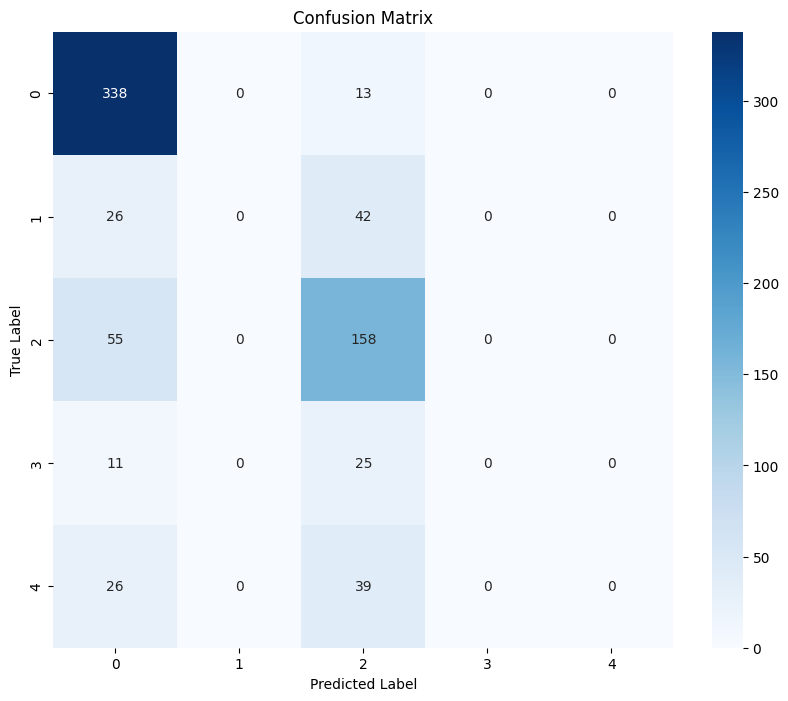

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [3]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Classification report with zero_division set to handle cases with no predicted samples
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, zero_division=1))

# ROC-AUC score (use predicted probabilities instead of class labels)
y_pred_prob = model.predict(X_test)  # Get the predicted probabilities
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob, multi_class='ovo')}")


ValueError: Expected all entries in the `metrics` list to be metric objects. Received instead:
metrics=[[<MeanMetricWrapper name=accuracy>]]